<a href="https://colab.research.google.com/github/sinhaji14/DEEP-LEARNING-PROJECT-FOR-PLACEMENT/blob/main/FRDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python


fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-j9cc3w_e
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-j9cc3w_e
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'


In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T


In [6]:
# Training augmentations:
# 1. Randomly flip images horizontally (p=0.5 probability).
# 2. Randomly rotate images between -20° and +20°.
# 3. Convert PIL/numpy images to Torch tensors (with channel order CxHxW).
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor()
])

# Validation augmentations:
# Only convert images to Torch tensors, no random changes (for consistency during validation).
valid_augs = T.Compose([
    T.ToTensor()
])

In [7]:
# Cell 8: Load dataset with augmentations
from torchvision.datasets import ImageFolder

# Load training dataset from the folder, applying training augmentations
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs)

# Load validation dataset from the folder, applying validation augmentations
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

In [8]:
# Cell 9: Print dataset sizes
# Display how many total examples are in training and validation sets
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [9]:
# Cell 10: Print class-to-index mapping
# Each class (like 'happy', 'sad', etc.) gets mapped to an integer index (0,1,2,...)
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


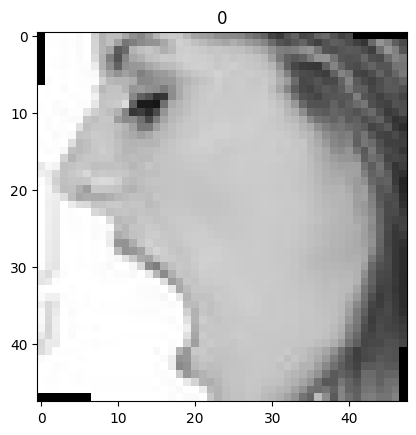

In [10]:
# Cell 11: Visualize one training example
import matplotlib.pyplot as plt

# Pick the 21st image and its label from the trainset
image, label = trainset[400]

# Convert from tensor (C,H,W) to numpy image (H,W,C) for visualization
plt.imshow(image.permute(1, 2, 0))

# Show the label (numeric class index)
plt.title(label)
plt.show()

In [11]:
# Cell 18: Create DataLoaders for training and validation datasets
from torch.utils.data import DataLoader

# Training DataLoader with shuffling (important for SGD training)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Validation DataLoader (no shuffle needed, since it's for evaluation)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [12]:
# Cell 19: Print number of batches in each DataLoader
# len(trainloader) = total_batches = total_examples / batch_size
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [13]:
# Cell 20: Inspect one batch of images and labels
# Iterate through trainloader, take the first batch, then break
for images, labels in trainloader:
    break;

# Print the shapes of the batch
# images.shape -> [batch_size, channels, height, width]
# labels.shape -> [batch_size]
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [14]:
# Cell 34: Import required libraries
import timm          # library for pretrained models (efficientnet, resnet, etc.)
from torch import nn # neural network building blocks


In [15]:
# Cell 35: Define FaceModel using EfficientNet-B0
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()

        # Load EfficientNet-B0 pretrained on ImageNet
        # num_classes=7 because dataset has 7 emotion classes
        self.eff_net = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            num_classes=7
        )

    def forward(self, images, labels=None):
        # Forward pass through EfficientNet
        logits = self.eff_net(images)

        # If labels are provided, also compute loss
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss

        # Otherwise, just return predictions
        return logits


In [16]:
# Instantiate the model
model = FaceModel()

# Move the model to the GPU (or CPU if CUDA not available)
model.to(DEVICE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

In [17]:
# Cell 40: Import tqdm for progress bars
from tqdm import tqdm


In [18]:

# Cell 41: Function to compute accuracy for multiclass classification
def multiclass_accuracy(y_pred, y_true):
    # Get the top predicted class index (highest probability)
    top_p, top_class = y_pred.topk(1, dim=1)

    # Compare predictions with true labels
    equals = top_class == y_true.view(*top_class.shape)

    # Return mean accuracy
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
# Training function for one epoch
def train_fn(model, dataloader, optimizer, current_epo):
    model.train()   # put model in training mode
    total_loss = 0.0
    total_acc = 0.0

    # tqdm adds a progress bar for batches
    tk = tqdm(dataloader, desc="EPOCH [TRAIN] " + str(current_epo+1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Step 1: Zero the gradients
        optimizer.zero_grad()

        # Step 2: Forward pass (get predictions and loss)
        logits, loss = model(images, labels)

        # Step 3: Backward pass (compute gradients)
        loss.backward()

        # Step 4: Update weights
        optimizer.step()

        # Track loss and accuracy
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)

        # Update tqdm bar with current metrics
        tk.set_postfix({'loss': '%.6f' % float(total_loss / (t+1)),
                        'acc' : '%.6f' % float(total_acc / (t+1))})

    # Return average loss and accuracy for this epoch
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [20]:
# Validation function (similar to train_fn but without gradient updates)
def eval_fn(model, dataloader, current_epo):
    model.eval()   # put model in evaluation mode
    total_loss = 0.0
    total_acc = 0.0

    tk = tqdm(dataloader, desc="EPOCH [VALID] " + str(current_epo+1) + "/" + str(EPOCHS))

    with torch.no_grad():   # no gradient computation during evaluation
        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            logits, loss = model(images, labels)

            # Track metrics
            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)

            # Update tqdm bar
            tk.set_postfix({'loss': '%.6f' % float(total_loss / (t+1)),
                            'acc' : '%.6f' % float(total_acc / (t+1))})

    # Return average validation loss and accuracy
    return total_loss / len(dataloader), total_acc / len(dataloader)


In [21]:
# Define optimizer (Adam) with model parameters and learning rate LR
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [22]:
# Initialize best validation loss with infinity
# so that the first epoch will always save weights
best_valid_loss = np.inf

# Training loop for given number of epochs
for i in range(EPOCHS):

    # ---- Training step ----
    # Runs one full pass on the training set
    # Returns average training loss and accuracy for the epoch
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)

    # ---- Validation step ----
    # Evaluates model on the validation set without gradient updates
    # Returns average validation loss and accuracy for the epoch
    valid_loss, valid_acc = eval_fn(model, validloader, i)

    # ---- Check for improvement ----
    # If the validation loss improves (is lower than before),
    # save the current model weights
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')  # Save the best weights
        print("SAVED-BEST-WEIGHTS")  # Log message
        best_valid_loss = valid_loss  # Update best validation loss

EPOCH [VALID] 1/15: 100%|██████████| 221/221 [00:05<00:00, 37.82it/s, loss=1.373673, acc=0.475004]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 2/15: 100%|██████████| 221/221 [00:04<00:00, 44.84it/s, loss=1.227374, acc=0.534122]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 3/15: 100%|██████████| 221/221 [00:05<00:00, 39.91it/s, loss=1.127199, acc=0.576847]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 4/15: 100%|██████████| 221/221 [00:06<00:00, 35.64it/s, loss=1.117172, acc=0.584972]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 5/15: 100%|██████████| 221/221 [00:05<00:00, 42.95it/s, loss=1.073509, acc=0.605225]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 6/15: 100%|██████████| 221/221 [00:04<00:00, 44.98it/s, loss=1.052039, acc=0.607455]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 8/15: 100%|██████████| 221/221 [00:05<00:00, 39.56it/s, loss=1.018982, acc=0.621062]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 10/15: 100%|██████████| 221/221 [00:05<00:00, 41.96it/s, loss=1.008999, acc=0.630645]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 12/15: 100%|██████████| 221/221 [00:04<00:00, 45.17it/s, loss=1.001792, acc=0.639380]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 14/15: 100%|██████████| 221/221 [00:05<00:00, 40.11it/s, loss=1.000705, acc=0.637955]


SAVED-BEST-WEIGHTS


EPOCH [VALID] 15/15: 100%|██████████| 221/221 [00:04<00:00, 44.74it/s, loss=1.004227, acc=0.639521]


Now that we have trained and saved the model, we can use it to make predictions on new images.

In [23]:
# Get one image and label from the validation set
image, label = validset[0]

# Move the image to the device
image = image.to(DEVICE)

# Add a batch dimension to the image
image = image.unsqueeze(0)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    logits = model(image)

# Get the predicted class index
_, predicted_class = torch.max(logits, dim=1)

# Print the predicted class index
print(f"Predicted class index: {predicted_class.item()}")

# You can also map the predicted class index back to the emotion label
idx_to_class = {v: k for k, v in trainset.class_to_idx.items()}
predicted_label = idx_to_class[predicted_class.item()]
print(f"Predicted emotion: {predicted_label}")

# Print the true label
true_label = idx_to_class[label]
print(f"True emotion: {true_label}")

Predicted class index: 4
Predicted emotion: neutral
True emotion: angry


In [25]:
# Load best weights before testing
model.load_state_dict(torch.load('best-weights.pt'))
model.eval()  # set to evaluation mode (disables dropout, batchnorm updates)


FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():  # no gradients needed during evaluation
    for images, labels in validloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # get predicted class

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print evaluation results
print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.46      0.53       960
           1       0.81      0.58      0.67       111
           2       0.54      0.41      0.47      1018
           3       0.89      0.79      0.84      1825
           4       0.58      0.61      0.59      1216
           5       0.44      0.67      0.53      1139
           6       0.74      0.78      0.76       797

    accuracy                           0.64      7066
   macro avg       0.66      0.62      0.63      7066
weighted avg       0.66      0.64      0.64      7066

Confusion Matrix:
 [[ 446    8  100   28  118  237   23]
 [  20   64    7    1   10    8    1]
 [  80    1  419   24  106  296   92]
 [  57    0   42 1450  117  109   50]
 [  42    1   49   71  738  281   34]
 [  68    4   92   16  173  767   19]
 [  13    1   68   34   20   38  623]]


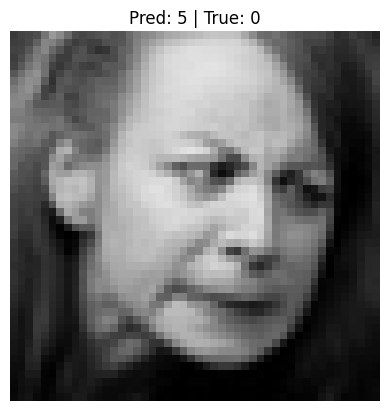

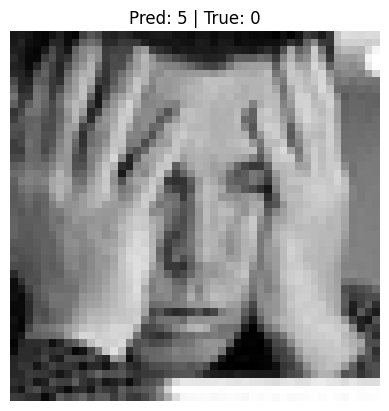

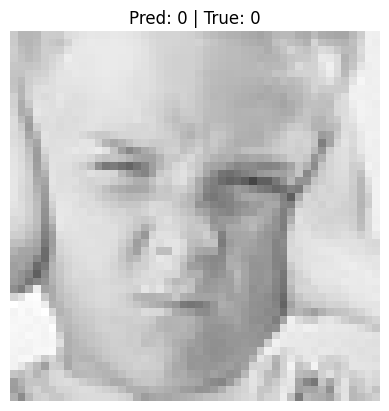

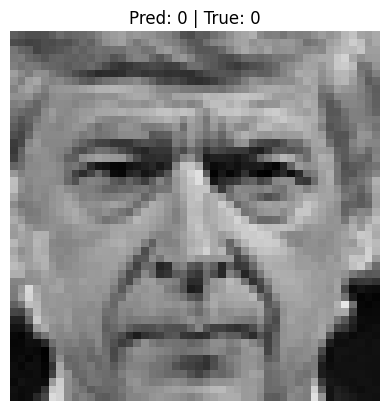

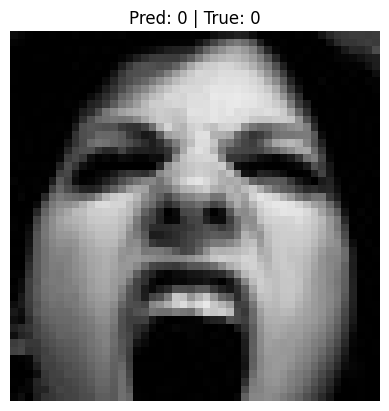

In [29]:
import matplotlib.pyplot as plt

def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Show a few sample predictions
dataiter = iter(validloader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

outputs = model(images)
_, preds = torch.max(outputs, 1)

for i in range(5):  # show first 5 images
    imshow(images[i], f"Pred: {preds[i].item()} | True: {labels[i].item()}")

In [30]:
import cv2
import torch
import torchvision.transforms as transforms

# Load best model
model.load_state_dict(torch.load("best-weights.pt"))
model.eval()

# Define preprocessing (same as training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((48, 48))  # match your dataset size
])

# Define label names (update with your classes)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale if your dataset was grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(gray, (48, 48))  # match model input size

    # Preprocess
    tensor = transform(face).unsqueeze(0)  # add batch dimension

    # Get prediction
    with torch.no_grad():
        outputs = model(tensor)
        _, pred = torch.max(outputs, 1)
        emotion = class_names[pred.item()]

    # Display prediction
    cv2.putText(frame, emotion, (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Emotion Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [31]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for button
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


In [32]:
torch.save(model.state_dict(), "best-weights.pt")


In [33]:
from google.colab import files
files.download("best-weights.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>